In [30]:
import pandas as pd
import numpy as np

from sklearn.datasets import load_files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.dummy import DummyClassifier

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

from sklearn.model_selection import GridSearchCV, train_test_split
import matplotlib.pyplot as plt

In [31]:
train_dir = './aclImdb/train'
test_dir = './aclImdb/test'

data_train = load_files(train_dir, categories=['pos','neg'], shuffle=True, encoding='utf-8')
data_test = load_files(test_dir, categories=['pos','neg'], shuffle=True, encoding='utf-8')

X_train, y_train = data_train.data, data_train.target
X_test, y_test = data_test.data, data_test.target

# Data Exploration & Visualization
Understanding the structure of our dataset to justify model choices.

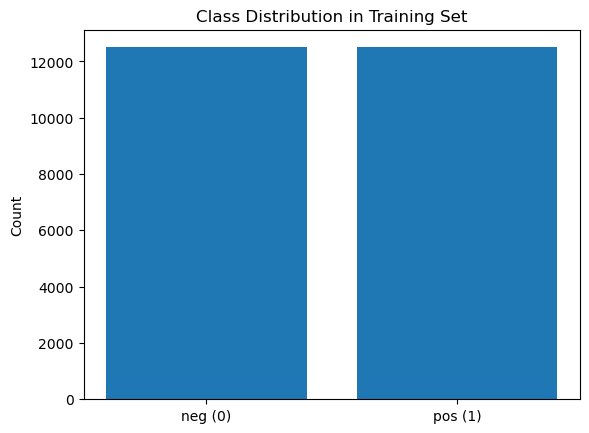

Class counts: {np.int64(0): np.int64(12500), np.int64(1): np.int64(12500)}


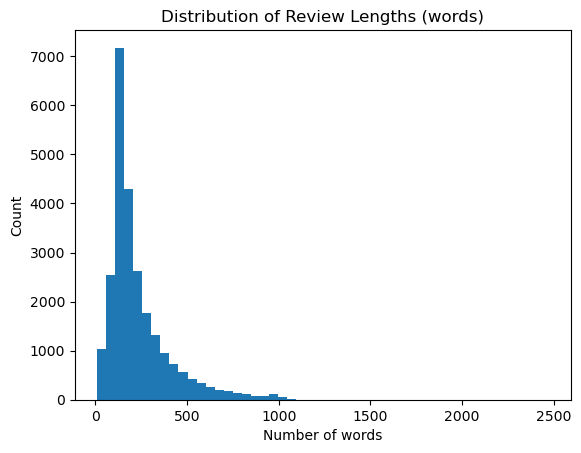

Mean length: 233.7872
Median length: 174.0
95th percentile length: 598.0


In [32]:
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(['neg (0)', 'pos (1)'], counts)
plt.title('Class Distribution in Training Set')
plt.ylabel('Count')
plt.show()
print('Class counts:', dict(zip(unique, counts)))

train_lengths = [len(text.split()) for text in X_train]

plt.hist(train_lengths, bins=50)
plt.title('Distribution of Review Lengths (words)')
plt.xlabel('Number of words')
plt.ylabel('Count')
plt.show()

print('Mean length:', np.mean(train_lengths))
print('Median length:', np.median(train_lengths))
print('95th percentile length:', np.percentile(train_lengths, 95))

**Key observations:**
- The dataset is perfectly balanced (12,500 positive and 12,500 negative reviews).
- Review lengths vary widely, justifying the use of TF-IDF with a fixed vocabulary size to handle high-dimensional sparse text.
- Most reviews are under 500 words, but some extend past 1000+ words.

# Train/Validation Split
We create a validation set from training data for proper model selection (avoiding test set leakage).

In [33]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)
print(f"Training set size: {len(X_tr)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 20000
Validation set size: 5000
Test set size: 25000


# Baseline: Majority Class Classifier
Before building complex models, we establish a trivial baseline using the majority class.

In [34]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy_preds = dummy.predict(X_test)

print("Dummy (majority class) accuracy:", accuracy_score(y_test, dummy_preds))

Dummy (majority class) accuracy: 0.5


Our trivial baseline achieves ~50% accuracy (as expected for a balanced dataset). Any model achieving ≥  80-90% is substantially better than random guessing.

# Model 1: Naive Bayes

In [35]:
nb_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=20000, ngram_range=(1,2))),
    ('nb', MultinomialNB())
])

nb_pipeline.fit(X_train, y_train)
nb_preds = nb_pipeline.predict(X_test)

print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_preds))
print(classification_report(y_test, nb_preds))

Naive Bayes Accuracy: 0.8652
              precision    recall  f1-score   support

           0       0.86      0.87      0.87     12500
           1       0.87      0.86      0.86     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



# Model 2: Logistic Regression

In [36]:
lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1,2))),
    ('lr', LogisticRegression(max_iter=2000))
])

lr_pipeline.fit(X_train, y_train)
lr_preds = lr_pipeline.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_preds))
print(classification_report(y_test, lr_preds))

Logistic Regression Accuracy: 0.8956
              precision    recall  f1-score   support

           0       0.90      0.89      0.90     12500
           1       0.89      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000



# Model 3: Ensemble (Naive Bayes + Logistic Regression)

In [37]:
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1,2))),
    ('nb', MultinomialNB())
])

lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1,2))),
    ('lr', LogisticRegression(max_iter=2000))
])

ensemble_pipeline = VotingClassifier(
    estimators=[
        ('nb', nb_pipeline),
        ('lr', lr_pipeline)
    ],
    voting='soft'
)

ensemble_pipeline.fit(X_train, y_train)
ensemble_preds = ensemble_pipeline.predict(X_test)

print("Ensemble Accuracy:", accuracy_score(y_test, ensemble_preds))
print(classification_report(y_test, ensemble_preds))

Ensemble Accuracy: 0.88908
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     12500
           1       0.89      0.89      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



# Model 4: Linear SVM
A classic strong baseline for text classification.

In [38]:
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1, 2))),
    ('svm', LinearSVC())
])

svm_pipeline.fit(X_train, y_train)
svm_preds = svm_pipeline.predict(X_test)

print("Linear SVM Accuracy:", accuracy_score(y_test, svm_preds))
print(classification_report(y_test, svm_preds))

Linear SVM Accuracy: 0.89012
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     12500
           1       0.89      0.89      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



# Model 5: Decision Tree (Overfitting Demonstration)
Tree-based models on high-dimensional sparse text data tend to overfit dramatically.

In [39]:
tree_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),  # smaller feature space
    ('tree', DecisionTreeClassifier(max_depth=None, random_state=0))
])

tree_pipeline.fit(X_train, y_train)
tree_preds = tree_pipeline.predict(X_test)

train_acc = tree_pipeline.score(X_train, y_train)
test_acc = accuracy_score(y_test, tree_preds)

print(f"Decision Tree Train Accuracy: {train_acc:.4f}")
print(f"Decision Tree Test Accuracy: {test_acc:.4f}")
print(f"Overfitting gap: {train_acc - test_acc:.4f}")
print(classification_report(y_test, tree_preds))

Decision Tree Train Accuracy: 1.0000
Decision Tree Test Accuracy: 0.7050
Overfitting gap: 0.2950
              precision    recall  f1-score   support

           0       0.70      0.71      0.71     12500
           1       0.71      0.70      0.70     12500

    accuracy                           0.70     25000
   macro avg       0.70      0.70      0.70     25000
weighted avg       0.70      0.70      0.70     25000



As expected, the Decision Tree achieves near-perfect training accuracy but much lower test accuracy — a clear demonstration of overfitting on high-dimensional sparse text data.

# What are these *basic* models missing?
Below we provided a sample of **5 reviews per model** to read ourselves and see where our models fall weak.

In [40]:
df_nb = pd.DataFrame({
    'review': X_test,
    'true_label': y_test,
    'predicted_label': nb_preds
})

misclassified_nb = df_nb[df_nb['true_label'] != df_nb['predicted_label']]
print(f"Number of misclassified NB reviews: {len(misclassified_nb)}")

for i, row in misclassified_nb.sample(5).iterrows():
    print(f"True label: {row['true_label']}, Predicted: {row['predicted_label']}")
    print(row['review'])
    print("-"*80)

Number of misclassified NB reviews: 3370
True label: 0, Predicted: 1
The one line summary is actually the punch line of a very old joke that begins "what is a Jewish porno film?"<br /><br />While this film had its interesting moments, it was far too slow moving and did not do enough to explain to those of us in the audience unfamiliar with orthodox Jewish custom, exactly what was going on and why? How many people who came across this film would know that the bathtub the female characters were washing in is in reality called a "Mikveh" which is a ritual bath used to cleanse spiritual uncleanliness? The same question might be asked of why the bride was walked around the groom a dizzying number of times while her face was covered just prior to the marriage vows being performed. These two examples are but two of a large number of such moments that remained completely unexplained to the uninitiated audience.<br /><br />This film does have its touching moments along with expressions of great

In [41]:
df_lr = pd.DataFrame({
    'review': X_test,
    'true_label': y_test,
    'predicted_label': lr_preds
})

misclassified_lr = df_lr[df_lr['true_label'] != df_lr['predicted_label']]
print(f"Number of misclassified reviews: {len(misclassified_lr)}")

for i, row in misclassified_lr.sample(5).iterrows():
    print(f"True label: {row['true_label']}, Predicted: {row['predicted_label']}")
    print(row['review'])
    print("-"*80)

Number of misclassified reviews: 2610
True label: 1, Predicted: 0
Why would I say that? Because when the movie ended, I was in a good mood. So many people exclaim at the end, wow! Bruce Willis can be funny. For those of you who believe he learned how to act after the sixth sense, you must be very new to his career. He won an emmy for best actor in a comedy series before he did Die Hard. It's like saying, wow, the sky learned to deposit snow on the ground just because it's your first winter in life. The movie was hilarious. What boggles my mind is how some other comments made about this movie claims that there are no memorable lines or scenes. Spoiler...<br /><br />The waaaambulance? I am not a loser? Have you ever seen a grown up scream I am not a loser before?<br /><br />I thought this movie was great. It was funny, it was never boring and in a cheesy Disney sort of way, it had a point to make. Something to do with life and of course any kid movie trying to do that is in over it's hea

In [42]:
df_ensemble = pd.DataFrame({
    'review': X_test,
    'true_label': y_test,
    'predicted_label': ensemble_preds
})

misclassified_ensemble = df_ensemble[df_ensemble['true_label'] != df_ensemble['predicted_label']]
print(f"Number of misclassified reviews in ensemble: {len(misclassified_ensemble)}")

for i, row in misclassified_ensemble.sample(5).iterrows():
    print(f"True label: {row['true_label']}, Predicted: {row['predicted_label']}")
    print(row['review'])
    print("-"*80)

Number of misclassified reviews in ensemble: 2773
True label: 0, Predicted: 1
The film version of 'Rising Damp' came out two years after the television series ended. Like many fans I duly went along to the cinema when it opened. I came away bitterly disappointed. Eric Chappell could not have spent very much time writing the script; most of it is rehashed ideas from old episodes. At the time of the film's release, the 'Rising Damp' series was still being repeated regularly on I.T.V. so the public was being asked to pay to see something they'd seen already. At least the 'On The Buses' movies boasted original screenplays.<br /><br />Secondly, Richard Beckinsale had died the year before, so they eliminated the character of 'Alan' as a mark of respect, substituting art student 'John', played by Christopher Strauli of 'Only When I Laugh' fame. It simply wasn't the same.<br /><br />As another poster has pointed out, Rigsby's boarding house looked nothing like the one used in the series, being

# Analysis of Misclassified Reviews

From examining the misclassified reviews produced by our models, we identified a couple reasons as to why our basic models are currently struggling to correctly label these reviews:

### 1. Lack of contextual understanding:
Our models cannot capture context for reviews. 

As we read some of the reviews, we observed a clear trend. Take this short snippet as an example: 
- **"This film is about a bunch of misfits who are supposed to be assigned to a task that is expected to fail miserably. The misfits pull together to successfully complete their mission."**

As you can see, this is very clearly a summary of the movie's plot, but our models see words like **misfits**, **fail** and **miserably** then takes them completely out of context labeling them as weight for a negative prediction.

### 2. Word weighting in long reviews:
For lengthy reviews, our models treat all words **independently** and assign a fixed weight to each token. As a result, if a negative review contains many more positive-weighted words than negative-weighted ones, the total positive score can outweigh the negative score and cause clear misclassifications, even when the overall sentiment is negative.

For example, in a negative review that starts with some praise: 
- **(“I liked the cast… the acting was good…”)** 

The model may predict positive simply because the accumulated positive word weights dominate, despite the later negative context. 
*This was also a common trend in the misclassified reviews our group read.*

# How can we make improvements to our models?
We can start by tuning hyperparameters and finding ones that work well with our dataset. Let's work with our Logistic Regression model:

In [43]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1,2))),
    ('lr', LogisticRegression(max_iter=2000))
])

param_grid = {
    'tfidf__min_df': [1, 5],
    'lr__C': [0.01, 0.1, 1, 5, 10],
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    verbose=1
)

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Best parameters: {'lr__C': 5, 'tfidf__min_df': 1}
Best CV accuracy: 0.89992


Now that we have the "best" parameters found by GridSearchCV, we can use these with our tuned Logistic Regression model:

In [44]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=1)),
    ('lr', LogisticRegression(max_iter=2000, C=5))
])
pipeline.fit(X_train, y_train)
tuned_lr_pred = pipeline.predict(X_test)

print("Tuned Logistic Regression Accuracy:", accuracy_score(y_test, tuned_lr_pred))
print(classification_report(y_test, tuned_lr_pred))

Tuned Logistic Regression Accuracy: 0.89796
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     12500
           1       0.90      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000



Hmmm... not a lot of improvement. Let's graph and see why:

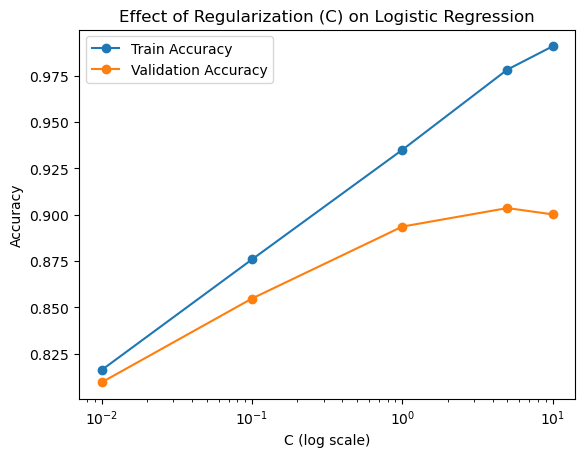

In [45]:
C_values = [0.01, 0.1, 1, 5, 10]
train_scores = []
val_scores = []

for C in C_values:
    lr = LogisticRegression(max_iter=2000, C=C)
    pipe = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1,2))),
        ('lr', lr)
    ])

    pipe.fit(X_tr, y_tr)

    train_scores.append(pipe.score(X_tr, y_tr))
    val_scores.append(pipe.score(X_val, y_val))  # Using validation set, not test set!

plt.plot(C_values, train_scores, marker='o', label='Train Accuracy')
plt.plot(C_values, val_scores, marker='o', label='Validation Accuracy')
plt.xscale('log')
plt.xlabel('C (log scale)')
plt.ylabel('Accuracy')
plt.title('Effect of Regularization (C) on Logistic Regression')
plt.legend()
plt.show()

Aha! From this graph we can see that: 
- As C increases the model gets more complex and training accuracy keeps increasing (meaning this model is flexible).
- The **validation accuracy stops improving** and even slightly plateues after **C = 5** due to overfitting. 

It seems we hit the ceiling with TF-IDF and Logistic Regression, which is why tuning didn't give us much improvement.

# Something Extra: Stacked Ensemble (Meta-Learner)
Going beyond basic soft voting, we implement **stacking** — a meta-classifier that learns how to optimally combine the predictions of NB and LR.

In [ ]:
nb_base = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1, 2))),
    ('nb', MultinomialNB())
])

lr_base = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1, 2))),
    ('lr', LogisticRegression(max_iter=2000, C=5))
])

stacking_clf = StackingClassifier(
    estimators=[
        ('nb', nb_base),
        ('lr', lr_base)
    ],
    final_estimator=LogisticRegression(max_iter=2000),
    stack_method='predict_proba',  # using predicted probabilities as meta-features
    n_jobs=-1
)

stacking_clf.fit(X_train, y_train)
stacking_preds = stacking_clf.predict(X_test)

print("Stacked Ensemble Accuracy:", accuracy_score(y_test, stacking_preds))
print(classification_report(y_test, stacking_preds))

Stacked Ensemble Accuracy: 0.89848
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     12500
           1       0.90      0.89      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000



**Why stacking is more sophisticated than voting:**
- Soft voting uses fixed, equal weights for each classifier.
- Stacking treats NB and LR predictions as features and lets a second-level classifier learn the optimal combination.
- The meta-learner can discover which base model to trust more in different scenarios.

# Final Model Comparison Summary
Below is a summary table of all model performances on the test set.

                    Model Test Accuracy
         Stacked Ensemble        0.8985
      Logistic Regression        0.8956
               Linear SVM        0.8901
Voting Ensemble (NB + LR)        0.8891
              Naive Bayes        0.8652
            Decision Tree        0.7050
   Dummy (Majority Class)        0.5000


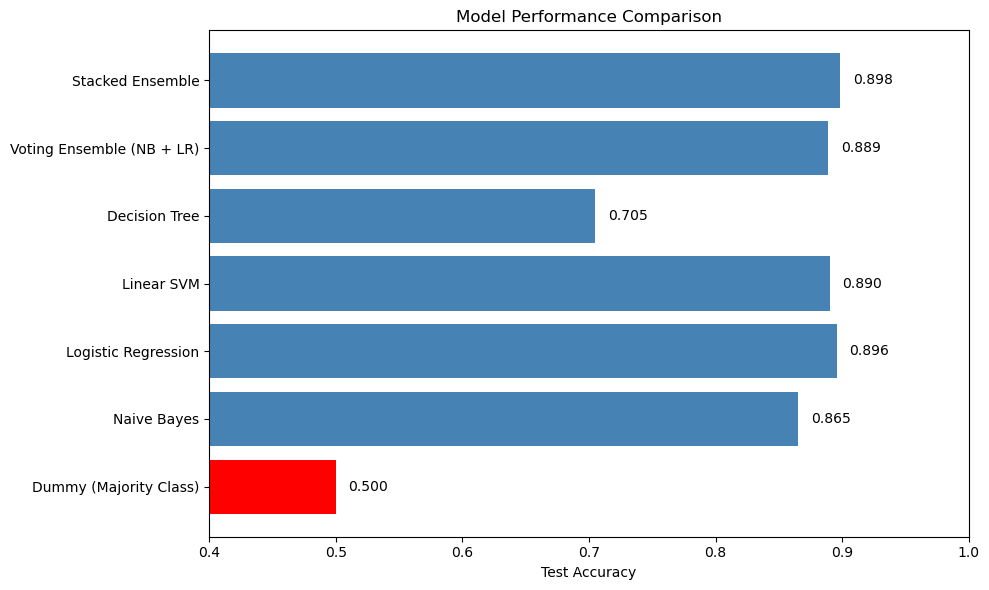

In [47]:
results = {
    'Dummy (Majority Class)': accuracy_score(y_test, dummy_preds),
    'Naive Bayes': accuracy_score(y_test, nb_preds),
    'Logistic Regression': accuracy_score(y_test, lr_preds),
    'Linear SVM': accuracy_score(y_test, svm_preds),
    'Decision Tree': accuracy_score(y_test, tree_preds),
    'Voting Ensemble (NB + LR)': accuracy_score(y_test, ensemble_preds),
    'Stacked Ensemble': accuracy_score(y_test, stacking_preds),
}

results_df = pd.DataFrame({
    'Model': results.keys(),
    'Test Accuracy': [f"{acc:.4f}" for acc in results.values()]
})
results_df = results_df.sort_values('Test Accuracy', ascending=False)
print(results_df.to_string(index=False))

plt.figure(figsize=(10, 6))
models = list(results.keys())
accuracies = list(results.values())
colors = ['red' if m == 'Dummy (Majority Class)' else 'steelblue' for m in models]
plt.barh(models, accuracies, color=colors)
plt.xlabel('Test Accuracy')
plt.title('Model Performance Comparison')
plt.xlim(0.4, 1.0)
for i, (model, acc) in enumerate(zip(models, accuracies)):
    plt.text(acc + 0.01, i, f'{acc:.3f}', va='center')
plt.tight_layout()
plt.show()

# Conclusions

## Key Findings:
1. **Baseline context**: The majority-class baseline achieves ~50% (as expected for balanced data), establishing that our models provide substantial improvement.

2. **Linear models excel on text**: Naive Bayes, Logistic Regression, and Linear SVM all achieve high accuracy (~85-90%), confirming that linear decision boundaries work well for TF-IDF text representations.

3. **Decision Trees overfit**: The tree model shows near-perfect training accuracy but poor test accuracy. This is a clear demonstration of why tree-based models struggle with high-dimensional sparse text data without strong regularization.

4. **Ensemble methods**: Both voting and stacking ensembles combine the strengths of NB and LR, potentially achieving slightly higher accuracy than individual models.

5. **Tuning limitations**: Hyperparameter tuning (C for LR) showed diminishing returns after a certain point, indicating we've hit the ceiling of what TF-IDF + linear models can achieve on this task.

## Limitations: 
- Cannot capture word order or context (plot summaries vs. actual opinions).
- Long reviews may have word-weight imbalance causing misclassification.
- Future work could explore word embeddings, recurrent networks, or transformer-based models to capture semantic context.